In [0]:
!git clone https://github.com/trongtuyen99/face-recogition


Cloning into 'face-recogition'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 2022 (delta 1), reused 3 (delta 0), pack-reused 2013
Receiving objects: 100% (2022/2022), 101.48 MiB | 31.58 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [0]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.layers.normalization import BatchNormalization

import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from keras.utils import np_utils
import itertools

Using TensorFlow backend.


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
def load_data(path_faces = r"/content/face-recogition/face_images"):
  keep_image = 45
  test = np.random.randn(128, 128) # fixed size
  X = np.array(test.reshape(1, *test.shape))
  Y = []
  for folder in os.listdir(path_faces):
    f = os.path.join(path_faces, folder)
    n = len(os.listdir(f)) # min(n) = 49
    Y += [str(folder)] * (45 * 5)
    for file in os.listdir(f)[:45]:
      file_path = os.path.join(f, file)
      img0 = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) # convert to gray scale
      img0 = cv2.resize(img0, (128, 128)) # to make all same size

      img = img0 / 255 #normalize every image
      X = np.concatenate((X, img.reshape(1, *img.shape)))
      # data agumentation

      img_noise = (img0 + 10*np.random.randn(*img0.shape))/255 # add gaussian noise
      X = np.concatenate((X, img_noise.reshape(1, *img0.shape)))

      w = img.shape[1]
      h = img.shape[0]
      M10 = cv2.getRotationMatrix2D((w/2,h/2), 10, 1) # rotate 10
      image1 = cv2.warpAffine(img,M10,(w,h))
      X = np.concatenate((X, image1.reshape(1, *img.shape)))

      M_10 = cv2.getRotationMatrix2D((w/2,h/2), -10, 1) # rotate -10
      image2 = cv2.warpAffine(img,M_10,(w,h))
      X = np.concatenate((X, image2.reshape(1, *img.shape)))
      
      flip = np.fliplr(img) # flip image
      X = np.concatenate((X, flip.reshape(1, *img.shape)))

  X = np.array(X)
  Y = np.array(Y)
  return X[1:], Y

X, Y = load_data()

# X: (2035, (128, 128))
# Y: (2035,)

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(Y)
Y = le.transform(Y)

In [0]:
label = ['11', '189', '204', '230', '244', '274', '4', '434', '459', '462',
       '478', '482', '509', '572', '576', '594', '660', '666', '680',
       '720', '731', '760', '777', '827', '94', '959', '994', '997',
       '998']

In [0]:
name_folder = {11: "khong ro ten", 
 189: "pewpew",
 204: "trung ruoi",
 230: "vanh leg",
 244: "quang thang", 
 274: "dinh la thang ko ro",
 4: "b girl ko ro", 
 434: "ms thy", 
 459: "huynh duc ko ro", 
 462: "bau duc", 
 478: "bui tien dung",
 482: "bui nhat anh",
 509: "vinh rau", 
 572: "virus",
 576: "bac j do",
 594: "quynh kool",
 660: "black bi",
 666: "viet johan",
 680: "chi xinh gai",
 720: "minh tit",
 731: "huynh phuong",
 760: "nguyen van duc",
 777: "mac van khoa",
 827: "phan manh quynh",
 94: "chi xinh dep",
 959: "duy manh",
 994: "chu tich vietjet air",
 997: "Den vau",
 998: "van dung"
 }

In [5]:
mapping_name = {}
for i, e in enumerate(label):
  mapping_name[i] = name_folder[int(e)]
print(mapping_name)

{0: 'khong ro ten', 1: 'pewpew', 2: 'trung ruoi', 3: 'vanh leg', 4: 'quang thang', 5: 'dinh la thang ko ro', 6: 'b girl ko ro', 7: 'ms thy', 8: 'huynh duc ko ro', 9: 'bau duc', 10: 'bui tien dung', 11: 'bui nhat anh', 12: 'vinh rau', 13: 'virus', 14: 'bac j do', 15: 'quynh kool', 16: 'black bi', 17: 'viet johan', 18: 'chi xinh gai', 19: 'minh tit', 20: 'huynh phuong', 21: 'nguyen van duc', 22: 'mac van khoa', 23: 'phan manh quynh', 24: 'chi xinh dep', 25: 'duy manh', 26: 'chu tich vietjet air', 27: 'Den vau', 28: 'van dung'}


In [0]:
x_train, x_valid, y_train, y_valid= train_test_split(
    X, Y, test_size=.05, random_state=8888,)

In [0]:
#filters= the depth of output image or kernels

batch_size=512
im_shape=(*X[0].shape, 1)

cnn_model= Sequential([
    Conv2D(filters=32, kernel_size=7, activation='relu', input_shape= im_shape),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=48, kernel_size=7, activation='relu', input_shape= im_shape),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=54, kernel_size=7, activation='relu', input_shape= im_shape),
    MaxPooling2D(pool_size=2),
    
    Flatten(),
    Dense(2024, activation='relu'),
     Dropout(0.4),
    Dense(1024, activation='relu'),
      Dropout(0.4),
    Dense(512, activation='relu'),
      Dropout(0.4),
    #29 is the number of outputs
    Dense(29, activation='softmax')  
])

cnn_model.compile(
    loss='sparse_categorical_crossentropy',#'categorical_crossentropy',
    optimizer=Adam(lr=0.0001),
    metrics=['accuracy']
)

In [0]:
x_train = x_train.reshape(x_train.shape[0], *im_shape)
x_valid = x_valid.reshape(x_valid.shape[0], *im_shape)

In [0]:
cnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 122, 122, 32)      1600      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 55, 55, 48)        75312     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 27, 27, 48)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 21, 21, 54)        127062    
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 10, 10, 54)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 5400)            

In [0]:
# Model: "sequential_4" => 0.9174 valid
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# conv2d_7 (Conv2D)            (None, 122, 122, 36)      1800      
# _________________________________________________________________
# max_pooling2d_7 (MaxPooling2 (None, 61, 61, 36)        0         
# _________________________________________________________________
# conv2d_8 (Conv2D)            (None, 57, 57, 54)        48654     
# _________________________________________________________________
# max_pooling2d_8 (MaxPooling2 (None, 28, 28, 54)        0         
# _________________________________________________________________
# flatten_4 (Flatten)          (None, 42336)             0         
# _________________________________________________________________
# dense_13 (Dense)             (None, 2024)              85690088  
# _________________________________________________________________
# dropout_10 (Dropout)         (None, 2024)              0         
# _________________________________________________________________
# dense_14 (Dense)             (None, 1024)              2073600   
# _________________________________________________________________
# dropout_11 (Dropout)         (None, 1024)              0         
# _________________________________________________________________
# dense_15 (Dense)             (None, 512)               524800    
# _________________________________________________________________
# dropout_12 (Dropout)         (None, 512)               0         
# _________________________________________________________________
# dense_16 (Dense)             (None, 29)                14877     
# =================================================================
# Total params: 88,353,819
# Trainable params: 88,353,819
# Non-trainable params: 0

In [0]:
history=cnn_model.fit(
    np.array(x_train), np.array(y_train), batch_size=512,
    epochs=150, verbose=2,
    validation_data=(np.array(x_valid),np.array(y_valid)),
)

Train on 6198 samples, validate on 327 samples
Epoch 1/200
 - 7s - loss: 3.3682 - accuracy: 0.0319 - val_loss: 3.3661 - val_accuracy: 0.0245
Epoch 2/200
 - 6s - loss: 3.3653 - accuracy: 0.0365 - val_loss: 3.3628 - val_accuracy: 0.0245
Epoch 3/200
 - 6s - loss: 3.3592 - accuracy: 0.0386 - val_loss: 3.3575 - val_accuracy: 0.0367
Epoch 4/200
 - 6s - loss: 3.3475 - accuracy: 0.0489 - val_loss: 3.3296 - val_accuracy: 0.0795
Epoch 5/200
 - 6s - loss: 3.3031 - accuracy: 0.0757 - val_loss: 3.2267 - val_accuracy: 0.1315
Epoch 6/200
 - 6s - loss: 3.1969 - accuracy: 0.1021 - val_loss: 3.0699 - val_accuracy: 0.1621
Epoch 7/200
 - 6s - loss: 3.0658 - accuracy: 0.1307 - val_loss: 2.9843 - val_accuracy: 0.1468
Epoch 8/200
 - 6s - loss: 2.9561 - accuracy: 0.1563 - val_loss: 2.7843 - val_accuracy: 0.2080
Epoch 9/200
 - 6s - loss: 2.7989 - accuracy: 0.1959 - val_loss: 2.6616 - val_accuracy: 0.2324
Epoch 10/200
 - 6s - loss: 2.6703 - accuracy: 0.2304 - val_loss: 2.5375 - val_accuracy: 0.2844
Epoch 11/200

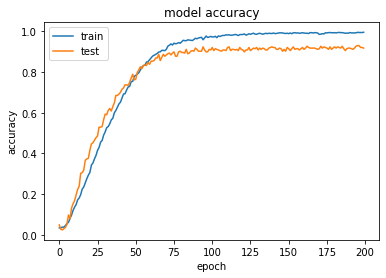

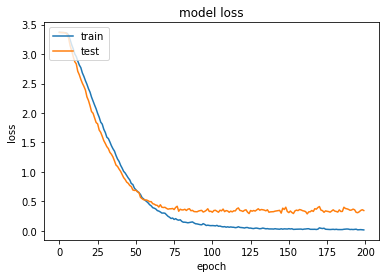

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# a = os.listdir()
import os
a = os.listdir("/content/face-recogition/face_images/11")
b = os.path.join("/content/face-recogition/face_images/11", a[0])

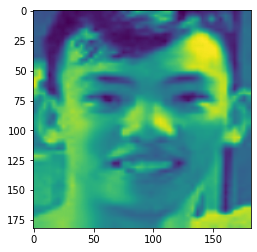

In [0]:
img = cv2.imread(b, cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
plt.show()

In [0]:
from keras.models import model_from_json
model_json = cnn_model.to_json()
with open("/content/drive/My Drive/model_92.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn_model.save_weights("/content/drive/My Drive/model_92.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('/content/drive/My Drive/model_92.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/model_92.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
score = loaded_model.evaluate(x_valid[:], y_valid[:], verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 91.74%


In [0]:
path_faces = r"/content/face-recogition/face_images"
minx = 400
for folder in os.listdir(path_faces):
  f = os.path.join(path_faces, folder)
  n = len(os.listdir(f))
  if n<minx:
    minx=n

In [0]:
loaded_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 122, 122, 32)      1600      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 55, 55, 48)        75312     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 27, 27, 48)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 21, 54)        127062    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 10, 54)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 5400)             

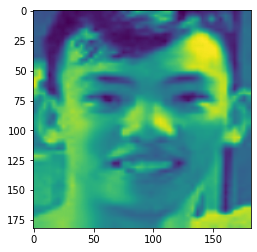

In [0]:
plt.imshow(img)

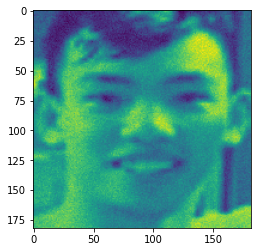

In [0]:
img2 = img + 10 * np.random.randn(182, 182) 
plt.imshow(img2)

In [0]:
keras.__version__

'2.3.1'

In [0]:
!zip model_92acc.zip "/drive/My Drive/label_encoder_92" "/content/drive/My Drive/model_92.h5" "/content/drive/My Drive/model_92.json"

	zip warning: name not matched: /drive/My Drive/label_encoder_92
  adding: content/drive/My Drive/model_92.h5 (deflated 8%)
  adding: content/drive/My Drive/model_92.json (deflated 89%)
